In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

 # Definitions

- The ***frequency*** refers to how often data points are being recorded. It should be constant.
- The interval between one point to the next is the ***time period***
- Time series data is ***time-dependent*** meaning the values for each period are affected by outside factors and by the values of past periods
- Time-series data suffers from ***seasonality*** -  variables like rain depend on the period of the year for example. We can anticipate those changes in our model.

Some ***notations***
T = entire period
t = a single period
X = Daily S&P 500 closings
Xt-1 = X at the previous period
We usually use dates as indexes in the dataframe.

When modeling, we can't shuffle the dataframe and pick the train and test sets. Because there is a chronological order, we choose a ***cut-off point*** - anything before will be the train and anything after will be the test.
Time series assume past periods patterns will persist in the future and that's how we forecast those future values.
We talk about ***extrapolation*** meaning we infer/predict future values outside of our known data based on existing trends while in common regression analysis, we do interpolation.
In TS, the further we go from the last known data point, the greater gets the uncertainty and so the error.

Some rules:
- ***Granularity Rule:*** This rule states that, more aggregate your forecasts are, the more accurate you are in your predictions. This is because aggregated data has lesser variance and hence, lesser noise.

- ***Frequency Rule:*** We need to update the data frequently in order to capture any new information available, which will make our forecasts, more accurate.

- ***Horizon Rule:*** Avoid making predictions, too much into the future. Meaning we should make prediction over a short duration of time and no too much into the future. This will give more accurate forecasts.

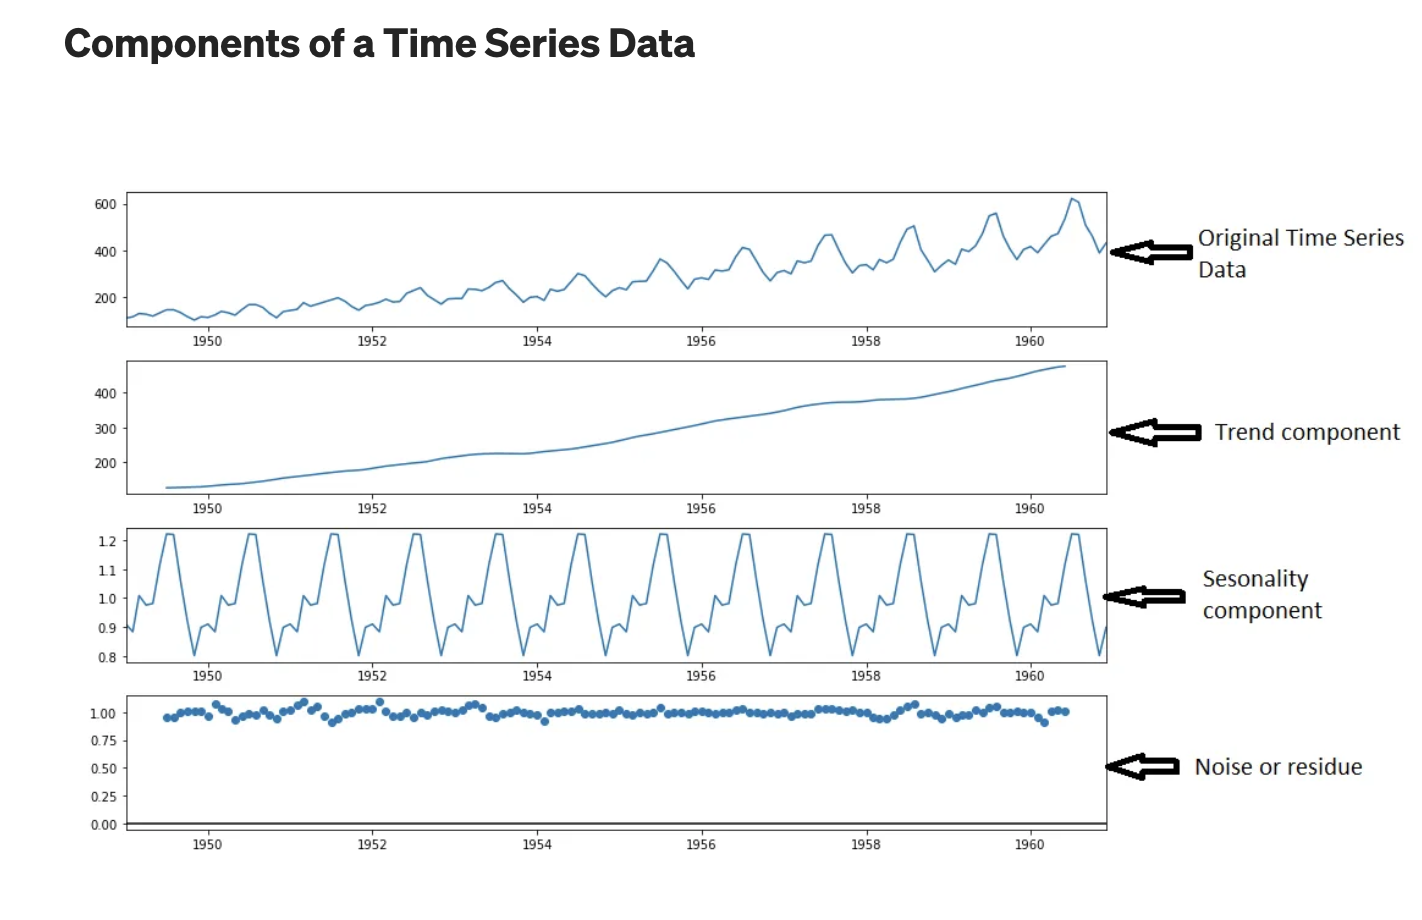

In [125]:
from IPython.display import Image,display

display(Image(filename='time_series_component.png'))

Let’s understand the meaning of each component, one by one.

- ***Level :*** Any time series will have a base line. To this base line we add different components to form a complete time series. This base line is known as level.
- ***Trend :*** It defines whether, over a period, time series increases or decreases. That is, it has an upward (increasing) trend or downward (decreasing) trend. For eg. the above time series has an increasing trend.
- ***Seasonality :*** It defines a pattern that repeats over a period. This pattern which repeats periodically is called as seasonality. In the above graph, we can clearly see the seasonality component present.
- ***Cyclicity :*** Cyclicity is also a pattern in the time series data but it repeats ***aperiodically***, meaning it doesn’t repeat after fixed intervals.
- ***Noise :*** After we extract level, trend, seasonality/cyclicity, what is left is noise. Noise is a completely random fluctuation in the data.

We get the above components when we decompose the time series. There are mainly two types of time series decomposition, namely:
- ***additive seasonal decomposition*** 
- ***multiplicative seasonal decomposition***

Simple way to understand this is,when the individual components of the time series at hand add up to get the original time series, it is called additive seasonal decomposition. 
In case, the individual components need to be multiplied to get the time series data, then it is called multiplicative seasonal decomposition. 
The main reason to use one type of decomposition over the other is that the residue should not have any pattern. That is, it should just be some random fluctuation

# Evaluation Metrics

- ***RMSE :*** ***Root Mean Squared Error*** is the square root of Mean Squared Error (MSE). MSE is nothing but a representation of how forecasted values differ from actual or true ones. We take the square root in order to avoid the negative sign as errors can be positive or negative. It is represented by the following formula :

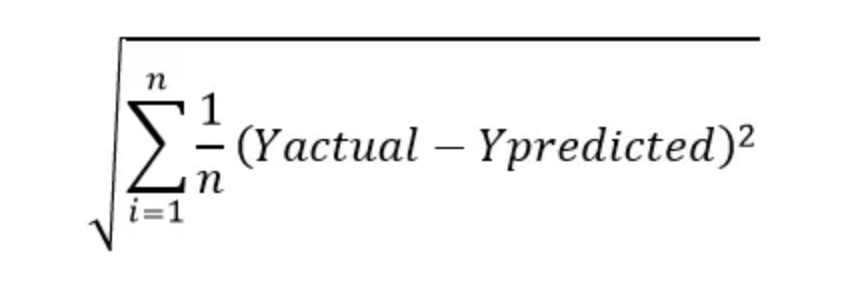

In [126]:
display(Image(filename='rmse.png'))

- ***MAPE :*** ***Mean Absolute Percentage Error*** is the measure of how accurate a forecast system is. It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time period minus actual values divided by actual values. It is represented by the following formula :

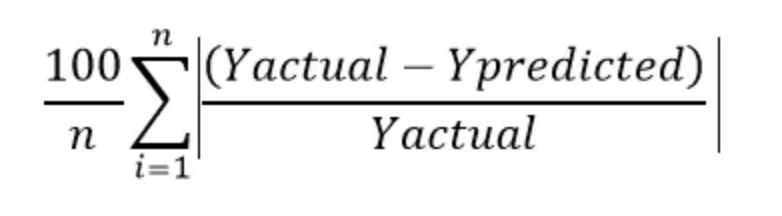

In [83]:
display(Image(filename='mape.png'))


Both RMSE and MAPE should be as low as possible.

# Business Example - Global Mart

***Problem Statement***

Global Mart is an online supergiant store that has worldwide operations. This store takes orders and delivers across the globe and deals with all the major product categories — consumer, corporate & home office.

As a sales manager for this store, you have to forecast the sales of the products for the ***next 6 months***, so that you have a proper estimate and can plan your inventory and business processes accordingly.

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation
from sklearn.metrics import mean_squared_error

In [129]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [128]:
df=pd.read_csv('GlobalSuperstoreData.csv')
df.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [130]:
# Dataframe shape
df.shape

(51290, 5)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


## 1. EDA

### 1.1 Missing values

In [132]:
# Check missing values
df.isnull().sum()

Order Date    0
Segment       0
Market        0
Sales         0
Profit        0
dtype: int64

### 1.2 Outliers

In [133]:
df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Sales,Profit
count,51290.000000,51290.000000
mean,246.490581,28.610982
std,487.565361,174.340972
min,0.444000,-6599.978000
25%,30.758625,0.000000
50%,85.053000,9.240000
75%,251.053200,36.810000
90%,632.225736,112.680000
95%,1015.955640,211.500000
99%,2301.000000,587.359950


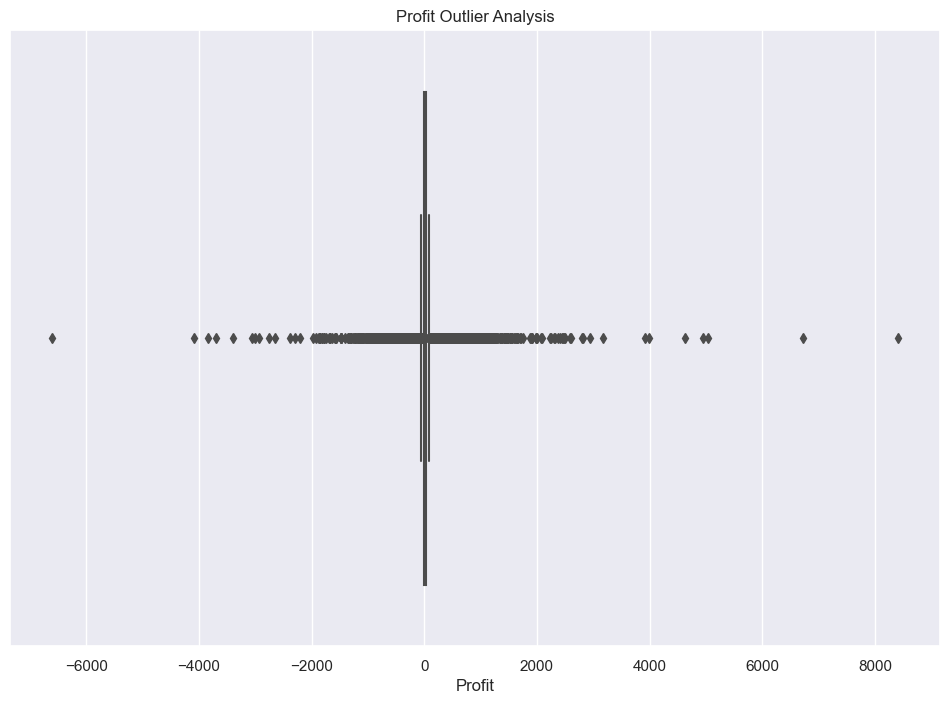

In [134]:
sns.boxplot(df['Profit']).set_title('Profit Outlier Analysis');
plt.show()

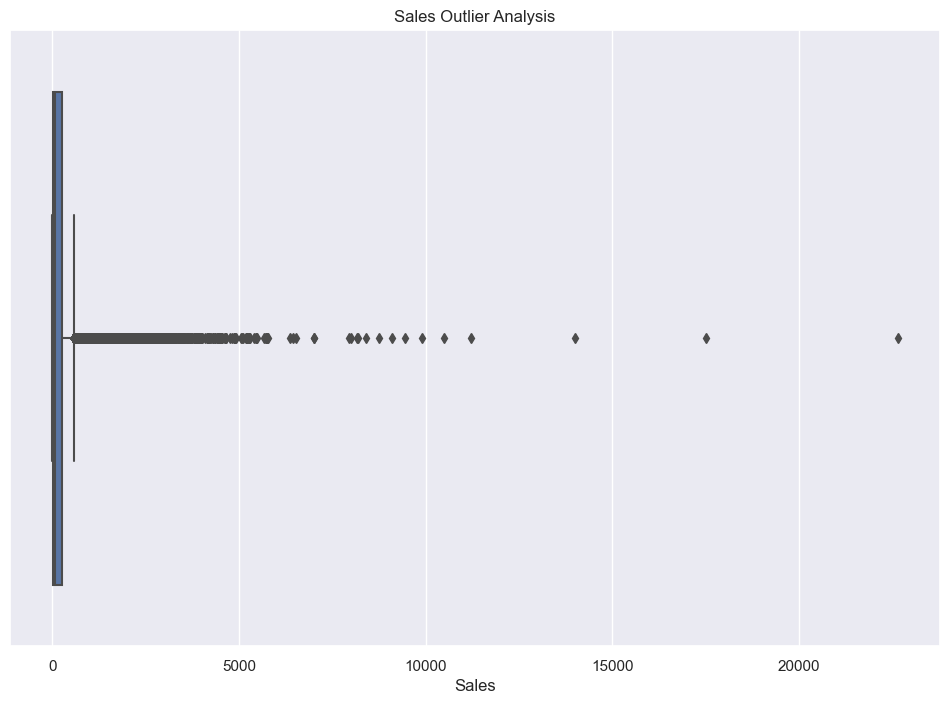

In [135]:
sns.boxplot(df['Sales']).set_title('Sales Outlier Analysis');
plt.show()

We can clearly see that there are outliers in the data.
We will keep the outliers as they are. We cannot delete them as this is a time series data and deleting any data point will lead to discontinuity in the data.

### 1.3 Univariate Analysis

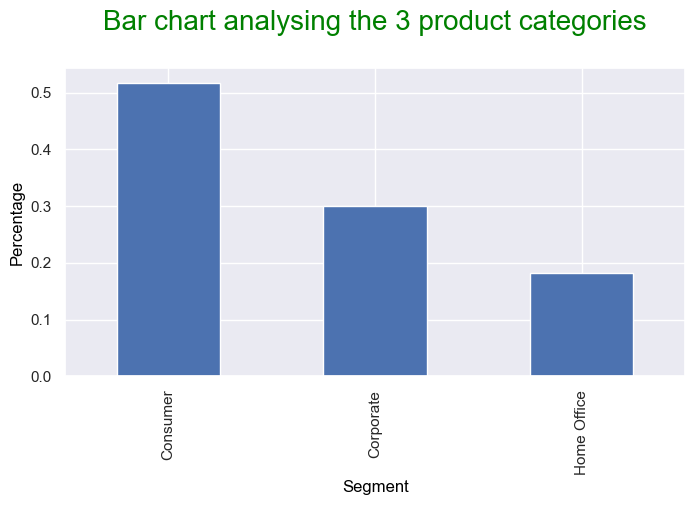

In [136]:
#Segment column
plt.figure(figsize= (8,4))
df["Segment"].value_counts(normalize=True).plot.bar()
plt.title("Bar chart analysing the 3 product categories\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("Segment", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Percentage", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

 ***Consumer category forms the most in demand product category worldwide for Global Mart.***

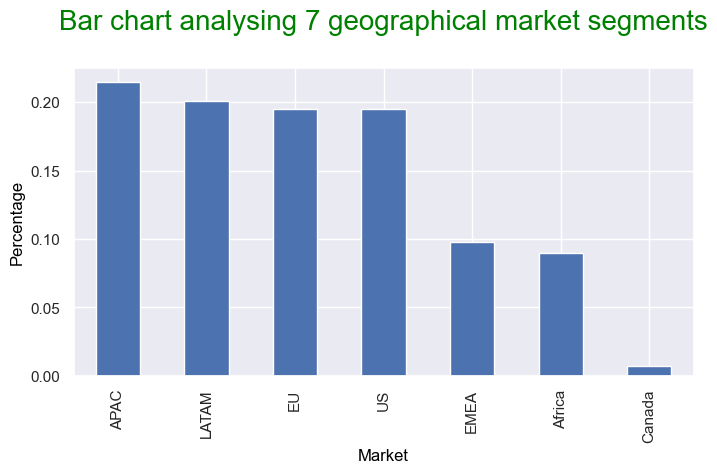

In [137]:
#Market column
plt.figure(figsize= (8,4))
df["Market"].value_counts(normalize=True).plot.bar()
plt.title("Bar chart analysing 7 geographical market segments\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("Market", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Percentage", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

***APAC segment is the most important market segment for Global Mart since most shipments take place in APAC region.***

### 1.4 Bivariate Analysis

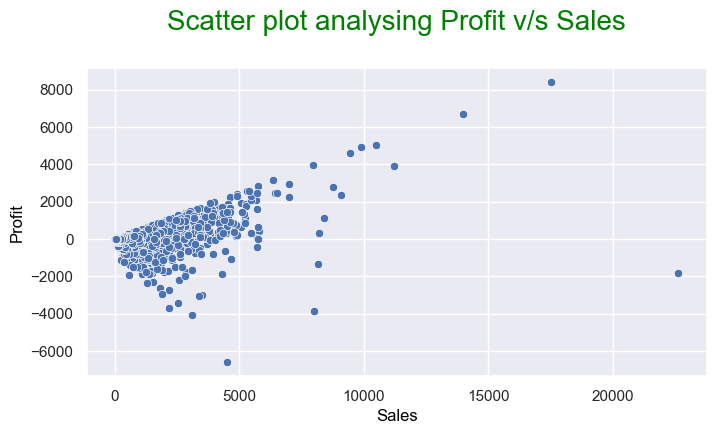

In [138]:
# Profit vs Sales
plt.figure(figsize= [8,4])
sns.scatterplot(df['Sales'], df['Profit'])
plt.title("Scatter plot analysing Profit v/s Sales\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("Sales", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Profit", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

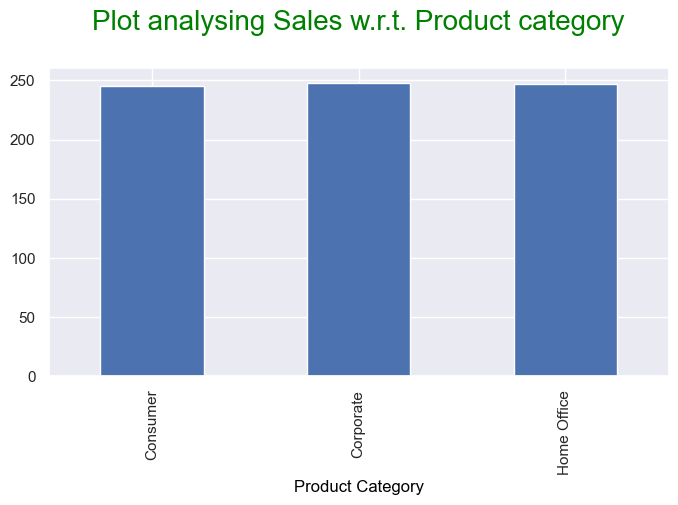

In [139]:
# Sales w.r.t. Product Category
plt.figure(figsize= (8,4))
df.groupby("Segment")["Sales"].mean().plot.bar()
plt.title("Plot analysing Sales w.r.t. Product category\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("Product Category", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.show()

Though Consumer is the leading category, Corporate category comprises of highest sales amounts.

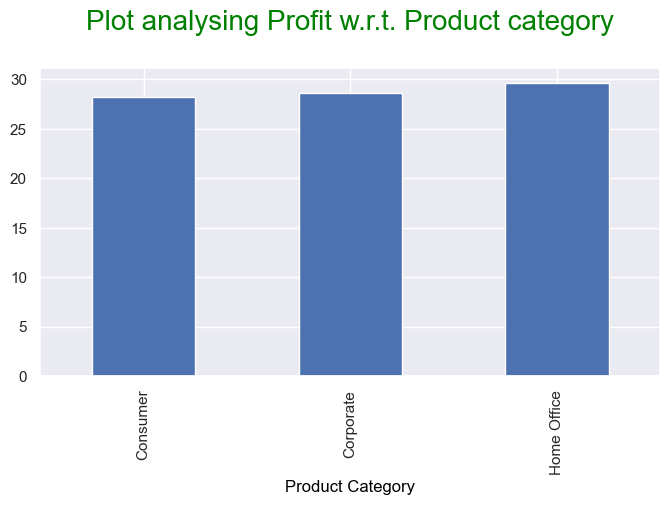

In [140]:
# Profit w.r.t. Product Category
plt.figure(figsize= (8,4))
df.groupby("Segment")["Profit"].mean().plot.bar()
plt.title("Plot analysing Profit w.r.t. Product category\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("Product Category", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.show()

***Home offices make highest profit***

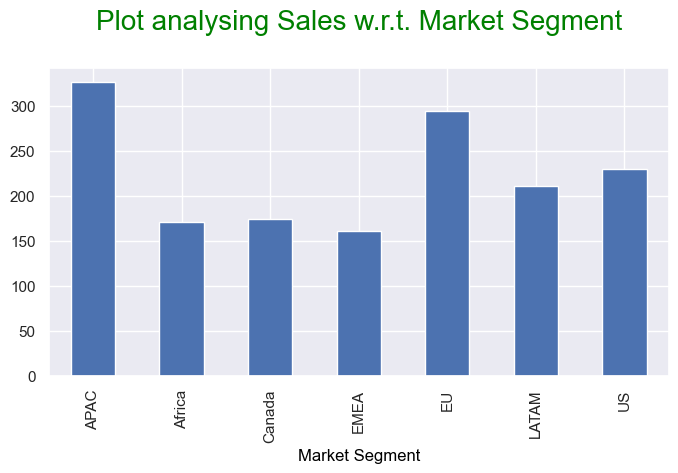

In [141]:
# Sales w.r.t. Market Segment
plt.figure(figsize= (8,4))
df.groupby("Market")["Sales"].mean().plot.bar()
plt.title("Plot analysing Sales w.r.t. Market Segment\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("Market Segment", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.show()

***APAC market makes highest sales***

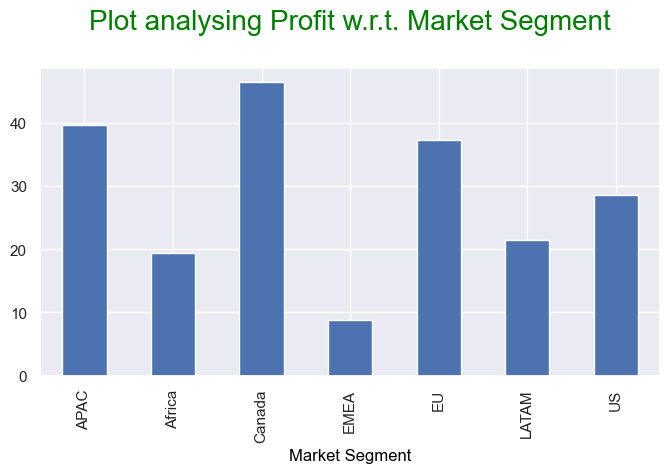

In [142]:
# Profit w.r.t. Market 
plt.figure(figsize= (8,4))
df.groupby("Market")["Profit"].mean().plot.bar()
plt.title("Plot analysing Profit w.r.t. Market Segment\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.xlabel("Market Segment", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.show()

***Canada market makes highest profit***

### 1.5 Multivariate Analysis

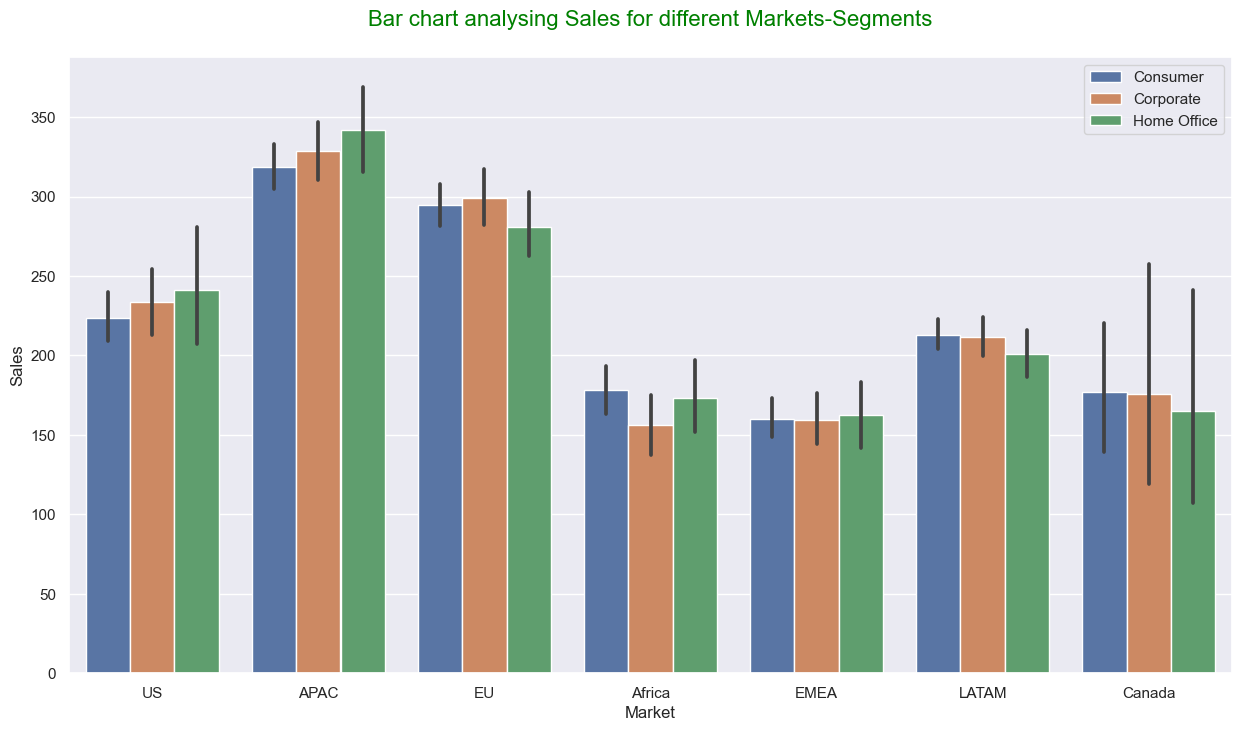

In [143]:
plt.figure(figsize=(15,8))
sns.barplot(data=df, x='Market', y= 'Sales', hue='Segment')
plt.title('Bar chart analysing Sales for different Markets-Segments\n', fontdict={'fontsize': 16, 'fontweight' : 5, 'color' : 'Green'})
plt.legend(loc = 'best')
plt.show()

***Inference: APAC- Home Office is the leading Market-Segment combination in terms of Sales***

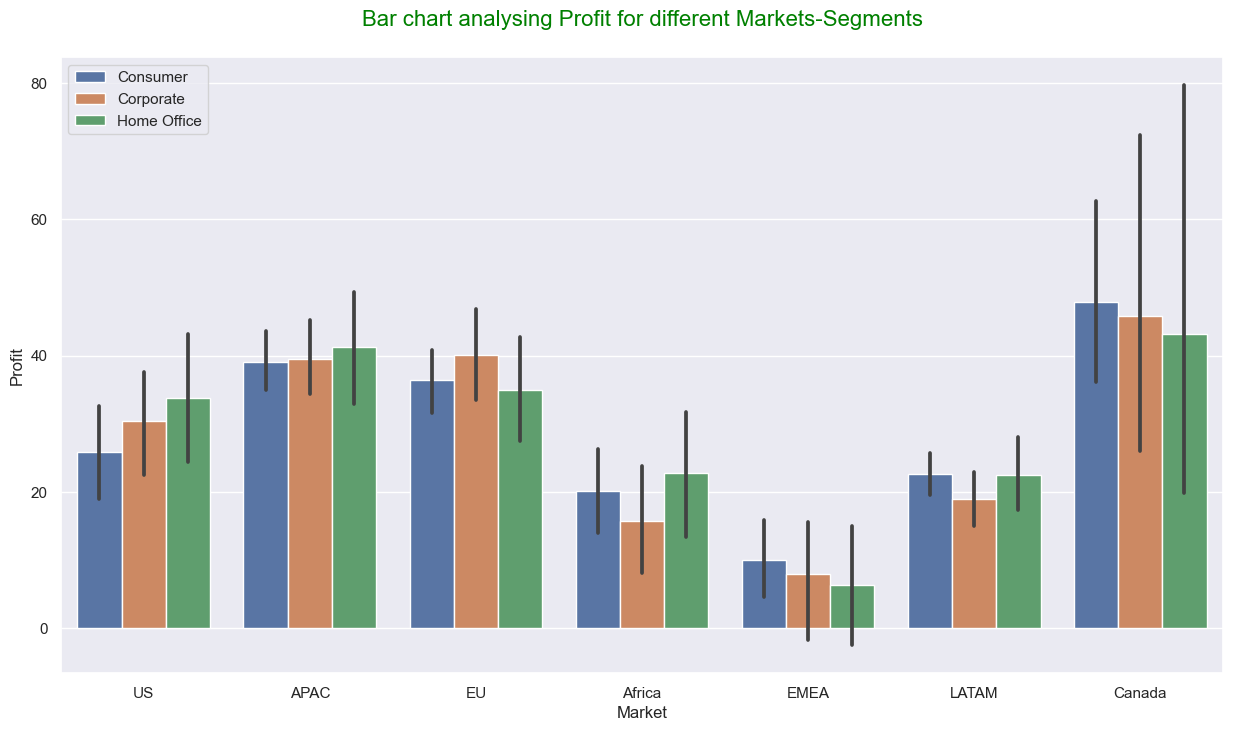

In [144]:
plt.figure(figsize=(15,8))
sns.barplot(data=df, x='Market', y= 'Profit', hue='Segment')
plt.title('Bar chart analysing Profit for different Markets-Segments\n', fontdict={'fontsize': 16, 'fontweight' : 5, 'color' : 'Green'})
plt.legend(loc = 'best')
plt.show()

***Inference: Consumer-Canada market is the leading Market-Segment combination in terms of Profit***

### 1.6 Create a Market-Segment column

In [145]:
df['Market_Segment']=df['Market']+ '_' + df['Segment']
df.head()

,Order Date,Segment,Market,Sales,Profit,Market_Segment
0,31-07-2012,Consumer,US,2309.650,762.1845,US_Consumer
1,05-02-2013,Corporate,APAC,3709.395,-288.7650,APAC_Corporate
2,17-10-2013,Consumer,APAC,5175.171,919.9710,APAC_Consumer
3,28-01-2013,Home Office,EU,2892.510,-96.5400,EU_Home Office
4,05-11-2013,Consumer,Africa,2832.960,311.5200,Africa_Consumer


In [146]:
df=df.drop(columns=['Segment','Market'])
df.head()

,Order Date,Sales,Profit,Market_Segment
0,31-07-2012,2309.650,762.1845,US_Consumer
1,05-02-2013,3709.395,-288.7650,APAC_Corporate
2,17-10-2013,5175.171,919.9710,APAC_Consumer
3,28-01-2013,2892.510,-96.5400,EU_Home Office
4,05-11-2013,2832.960,311.5200,Africa_Consumer


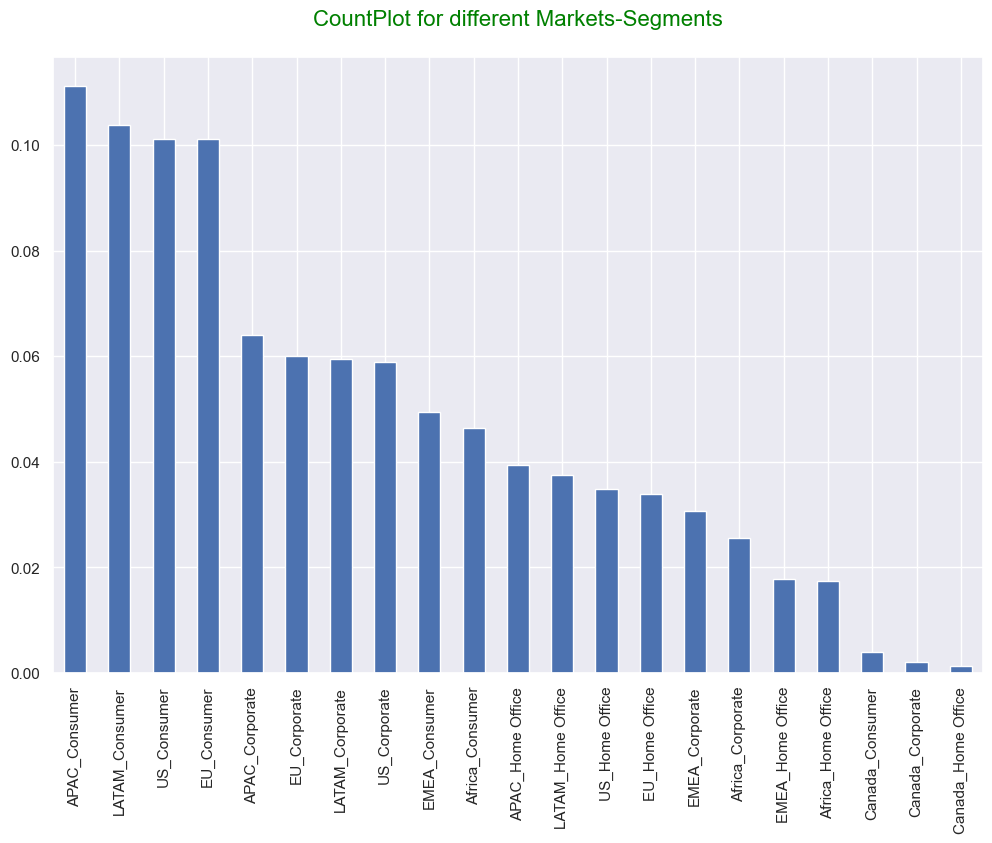

In [147]:
df['Market_Segment'].value_counts(normalize=True).sort_values(ascending=False).plot.bar();
plt.title('CountPlot for different Markets-Segments\n', fontdict={'fontsize': 16, 'fontweight' : 5, 'color' : 'Green'})
plt.show()

## 2. Preparing the data

### 2.1 Convert the Order Date column into datetime formats

In [148]:
# Converting the Order Date to month-Year format
df['Order Date'] = pd.to_datetime(df['Order Date']).dt.to_period('m') 
df.head()

,Order Date,Sales,Profit,Market_Segment
0,2012-07,2309.650,762.1845,US_Consumer
1,2013-05,3709.395,-288.7650,APAC_Corporate
2,2013-10,5175.171,919.9710,APAC_Consumer
3,2013-01,2892.510,-96.5400,EU_Home Office
4,2013-05,2832.960,311.5200,Africa_Consumer


In [149]:
#We order the data chronologically
df=df.sort_values(by='Order Date')
df.head()

,Order Date,Sales,Profit,Market_Segment
15262,2011-01,139.65,15.30,EU_Corporate
26744,2011-01,88.44,15.84,EU_Consumer
48614,2011-01,11.43,4.11,EU_Corporate
9417,2011-01,491.00,122.70,LATAM_Consumer
48590,2011-01,4.71,0.00,US_Home Office


### 2.2 Monthly Aggregated data

In [150]:
df_profit= df.pivot_table( index='Order Date',values='Profit', columns='Market_Segment' ,aggfunc='sum')
df_profit.head()

Market_Segment,APAC_Consumer,APAC_Corporate,APAC_Home Office,Africa_Consumer,Africa_Corporate,Africa_Home Office,Canada_Consumer,Canada_Corporate,Canada_Home Office,EMEA_Consumer,...,EMEA_Home Office,EU_Consumer,EU_Corporate,EU_Home Office,LATAM_Consumer,LATAM_Corporate,LATAM_Home Office,US_Consumer,US_Corporate,US_Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


In [151]:
df_profit.shape

(48, 21)

***We got the data for 48 months now for the 21 Market_Segments***

### 2.3 Train-Test Split

In [152]:
# perform the train-test split such that you take the 42 months as the train data and the 6 months as the test data.
train_len = 42
train = df_profit[:train_len] # first 42 months as training set
test = df_profit[train_len:] # last 6 months as test set

### 2.4 Calculate the CoV on the profit for each of the 21 market segments on the train data.

***Coefficient of variation*** is a ratio of the standard deviation to mean. We need to find the market segment for which value of Coefficient of variation is the least for profit. This is because, less standard deviation means less variation in profit, which means more consistent are the profit figures for that region over the given period. We calculate the Coefficient of Variation for each of the 21 market segments for 42 months(train data) to decide which market segment is consistently profitable.

In [153]:
mean=np.mean(train)
std= np.std(train)

CoV_df= pd.DataFrame(mean)
CoV_df['std']= std
CoV_df['CoV'] = std/mean
CoV_df= CoV_df.reset_index()
CoV_df.columns= ['Market_Segment', 'Mean', 'Std', 'CoV']
CoV_df.sort_values(by='CoV', ascending= True, inplace = True)
CoV_df

,Market_Segment,Mean,Std,CoV
0,APAC_Consumer,4400.894243,2300.457687,0.522725
1,APAC_Corporate,2574.919807,1364.837734,0.530051
12,EU_Consumer,3699.977143,2202.282289,0.595215
15,LATAM_Consumer,2295.555697,1569.632686,0.683770
13,EU_Corporate,2216.299429,1600.336696,0.722076
16,LATAM_Corporate,1122.633016,990.360880,0.882177
14,EU_Home Office,1224.456536,1148.627937,0.938072
2,APAC_Home Office,1511.088314,1523.508658,1.008219
18,US_Consumer,2686.740912,2715.031412,1.010530
19,US_Corporate,1754.199083,1880.200775,1.071829


***The APAC_Consumer Market-Segment is the most consistent one in terms of profit***

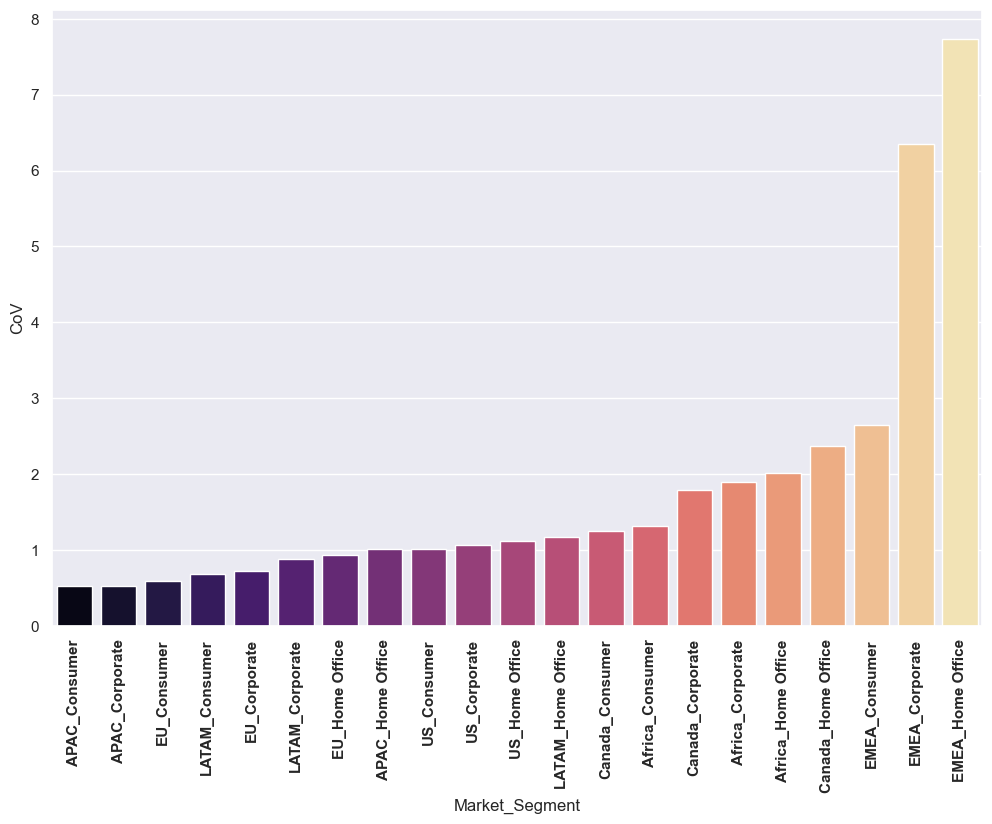

In [154]:
sns.barplot(x='Market_Segment', y= 'CoV', data=CoV_df, palette='magma')
plt.xticks(rotation = 90,fontweight="bold")
plt.show()

### 2.5 Keeping only APAC_Consumer data

In [155]:
df_apac=df[df['Market_Segment']=='APAC_Consumer'].reset_index(drop=True)
df_apac

,Order Date,Sales,Profit,Market_Segment
0,2011-01,1429.0500,371.4900,APAC_Consumer
1,2011-01,219.7800,59.3400,APAC_Consumer
2,2011-01,342.5100,54.6000,APAC_Consumer
3,2011-01,102.7620,1.8420,APAC_Consumer
4,2011-01,420.4200,147.0000,APAC_Consumer
...,...,...,...,...
5694,2014-12,243.6840,-89.3760,APAC_Consumer
5695,2014-12,39.0000,7.3800,APAC_Consumer
5696,2014-12,100.4964,-12.1836,APAC_Consumer
5697,2014-12,608.5800,0.0000,APAC_Consumer


### 2.6 - Aggregating the sales by month

In [156]:
df_apac=pd.DataFrame(df_apac.groupby("Order Date")['Sales'].sum())
df_apac.head()

,Sales
Order Date,
2011-01,18821.9898
2011-02,23313.3531
2011-03,26518.4919
2011-04,12046.0923
2011-05,25941.9000


## 3 - Time Series Analysis

### 3.1 - Plot time series

In [157]:
data=df_apac

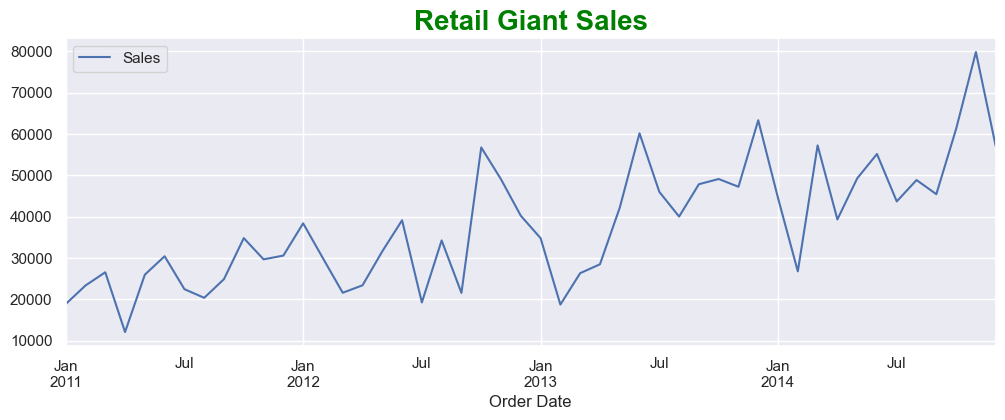

In [158]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Retail Giant Sales', fontweight='bold', size=20,color='green')
plt.show()

## 3.2 - Split data into train and test

In [159]:
train_len = 42
train = data[0:train_len] 
test = data[train_len:] 

In [160]:
data.index=data.index.to_timestamp()

In [165]:
test.index=test.index.to_timestamp()

## 3.3 - Time series decomposition

### 3.3.1 - Additive seasonal decomposition

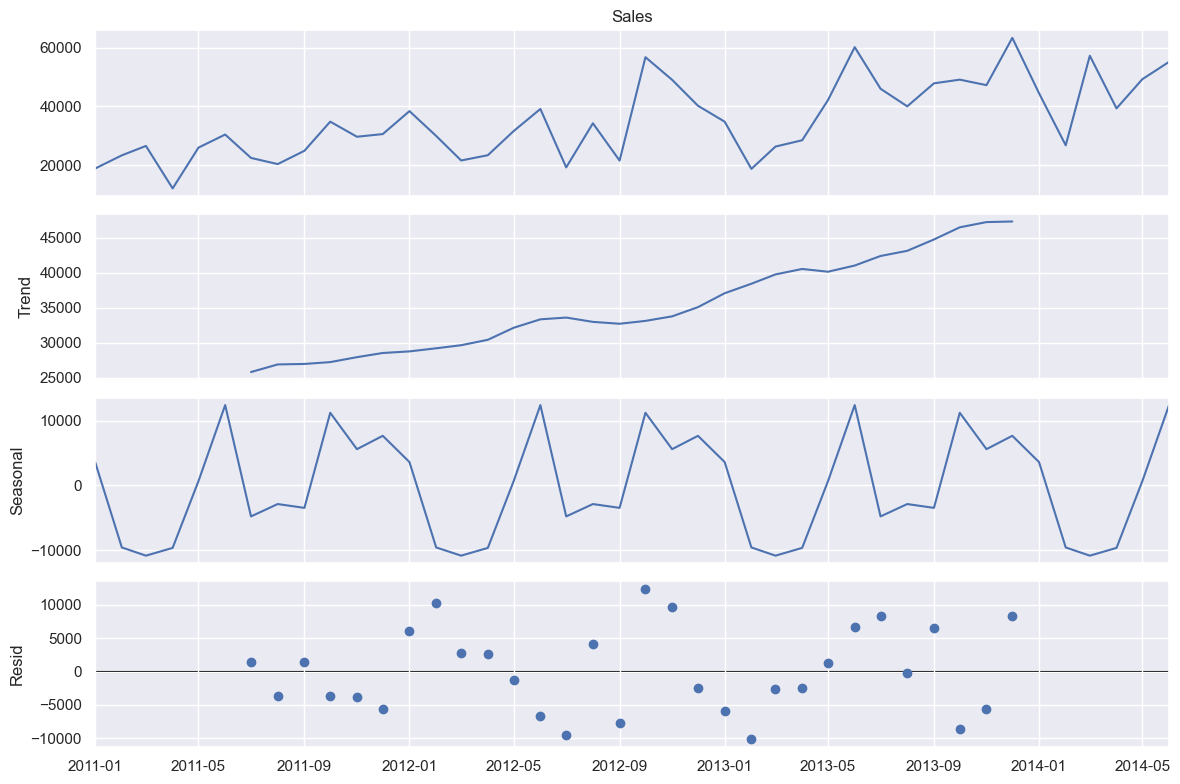

In [161]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
train.index=train.index.to_timestamp()
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### 3.3.2 - Multiplicative seasonal decomposition

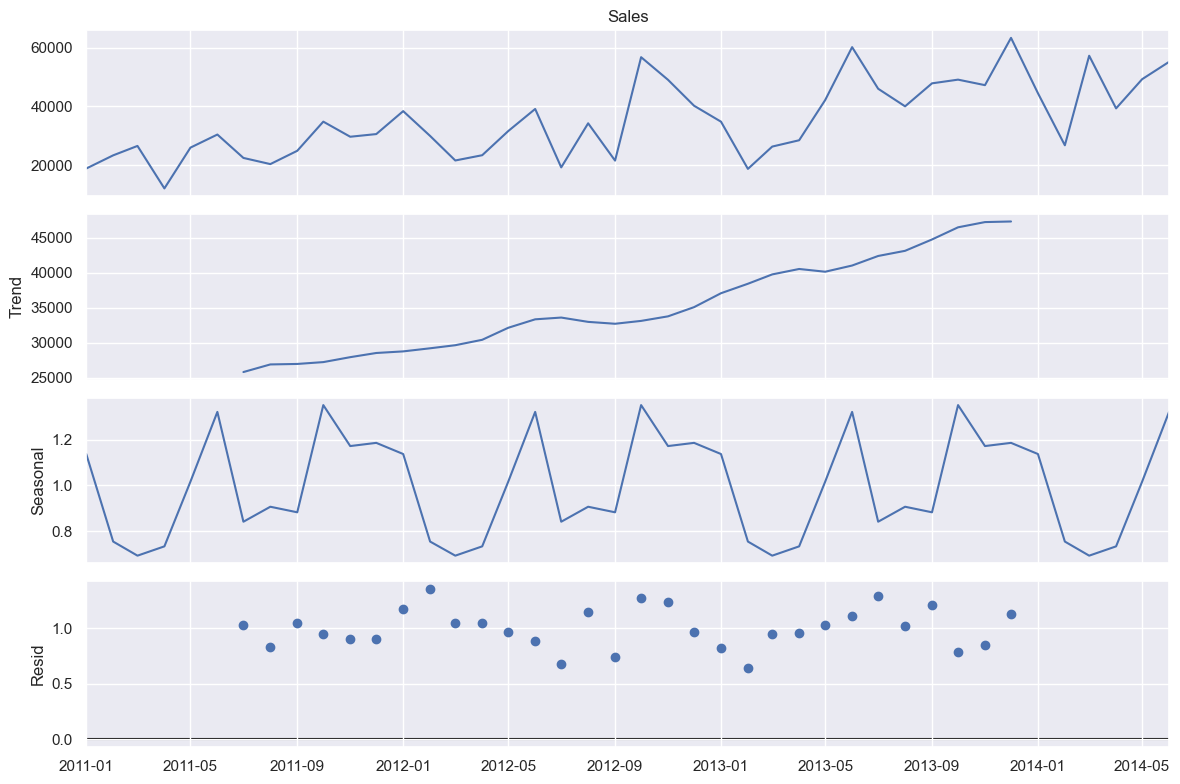

In [162]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(train.Sales, model='multiplicative') # additive seasonal index
fig = decomposition.plot()
plt.show()

## 4 - Time Series Forecasting Methods

### 4.1 - Simple Methods

#### 4.1.1 - Naive Method

#### Forecast = Last month sales

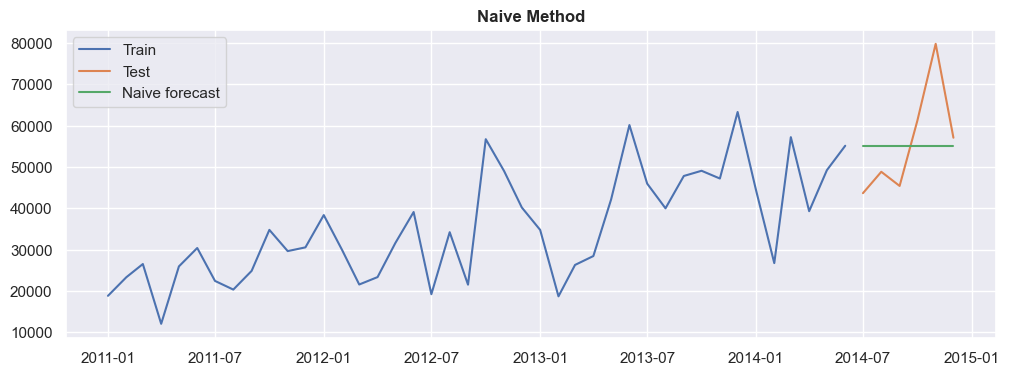

In [166]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Sales'][train_len-1] #Last observation in the train data
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method', fontweight= 'bold')
plt.show()

In [167]:
# Calculating RMSE and MAPE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results

,Method,MAPE,RMSE
0,Naive method,17.47,12355.97


#### 4.1.2 - Simple Average Method

#### Forecast = Average of all past months’ sales

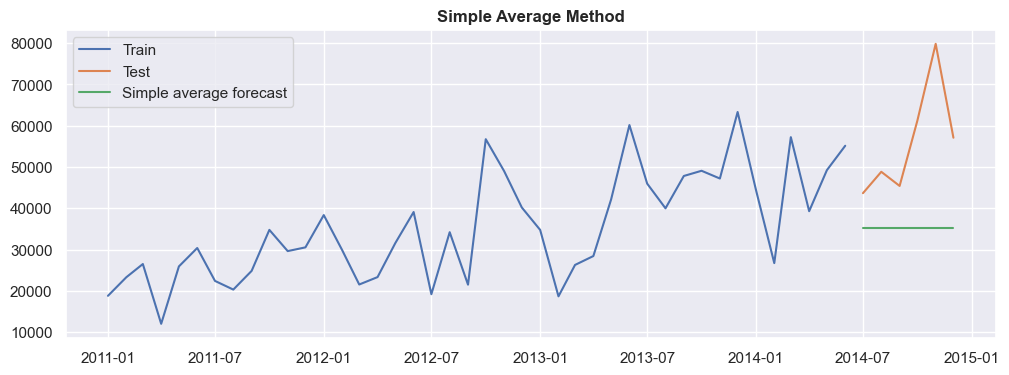

In [168]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method', fontweight='bold')
plt.show()

In [169]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_avg['avg_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34


#### 4.1.3 - Simple Moving Average Method

#### Forecast= Average of only the last few observations to forecast the future

In [170]:
y_hat_sma = data.copy()
ma_window = 3
y_hat_sma['sma_forecast'] = y_hat_sma['Sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][len(train):] = y_hat_sma['sma_forecast'][len(train)-1]

In [171]:
ma6_window=6
y_hat_sma['sma_forecast_6'] = y_hat_sma['Sales'].rolling(ma6_window).mean()
y_hat_sma['sma_forecast_6'][len(train):] = y_hat_sma['sma_forecast_6'][len(train)-1]

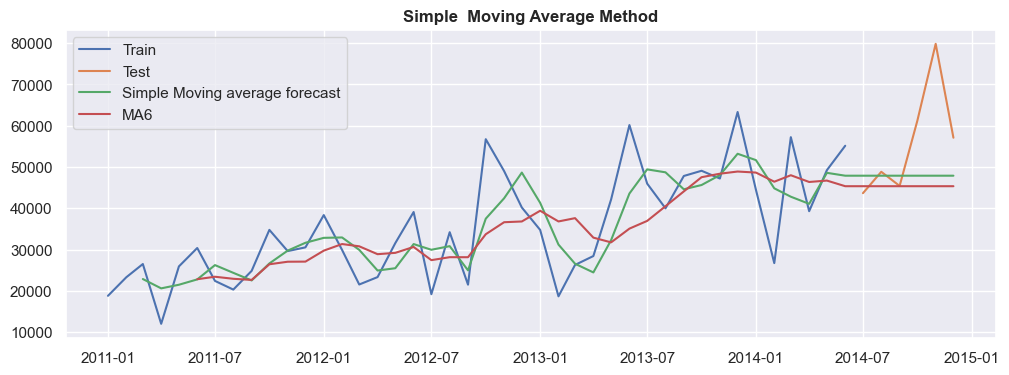

In [172]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple Moving average forecast')
plt.plot(y_hat_sma['sma_forecast_6'], label='MA6')
plt.legend(loc='best')
plt.title('Simple  Moving Average Method', fontweight='bold')
plt.show()

In [173]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sma['sma_forecast'][42:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sma['sma_forecast'][42:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82


### 4.2 - Exponential smoothing methods

#### 4.2.1 - Simple exponential smoothing

- The most recent period's demand multiplied by the smoothing factor.
-  It is a time series forecasting method for univariate data without a trend or seasonality.
- The simple exponetial model captures the level of a time series.

In [174]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)

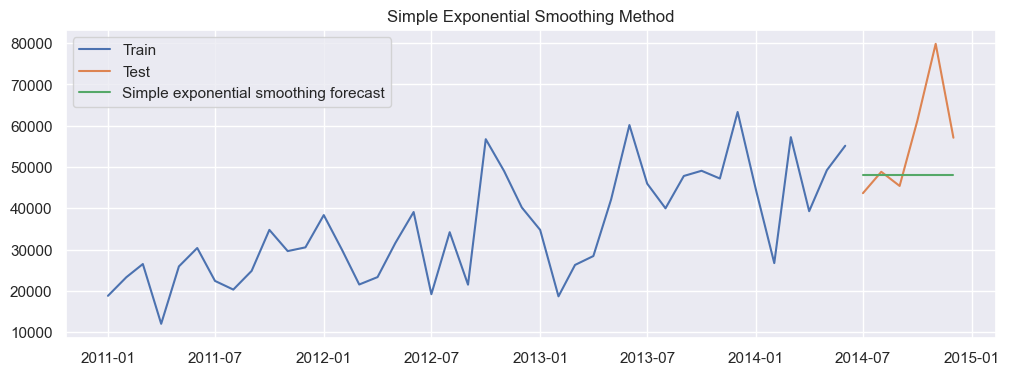

In [175]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [176]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74


#### 4.2.2 - Holt's Exponential Smoothing

***We can use this method if the TS has trend and seasonality but not if it is random. In most sales graphs, there is a trend and seasonality so it is relevant to use this method***.

***Captures both level and trend of a time series in the forecast.***

In [177]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 18638.663519999995, 'initial_trend': 964.8086345454556, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


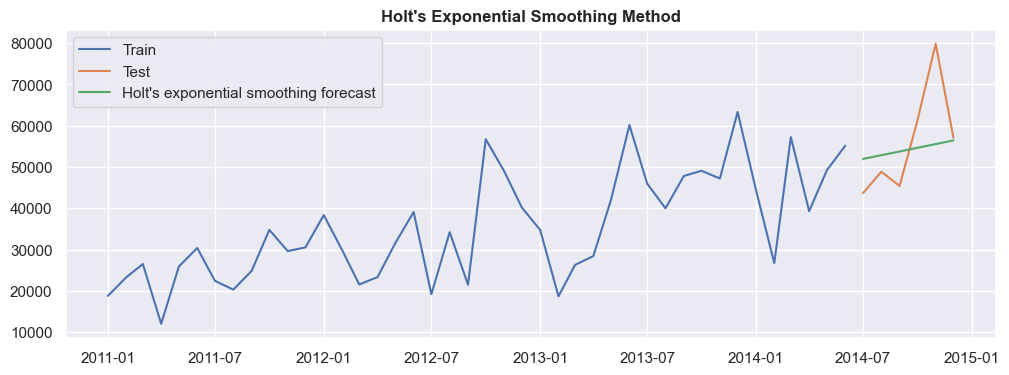

In [178]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method', fontweight='bold')
plt.show()

In [179]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64


**Inference : Holt's exponential smoothing method performs better than Simple exponential smoothing.**

#### 4.2.3 - Holt's Exponential Additive Smoothing with seasonality

In [180]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.005, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.0001, 'damping_trend': nan, 'initial_level': 25546.140294166653, 'initial_trend': 468.00483560606244, 'initial_seasons': array([  3952.88057396,  -9211.53080729, -10479.58736354,  -9282.54725729,
         1016.15604896,  12737.03211146,  -8578.55198854,  -2357.83653854,
        -6344.09922604,  15891.83603021,   8787.51308021,   3868.73533646]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


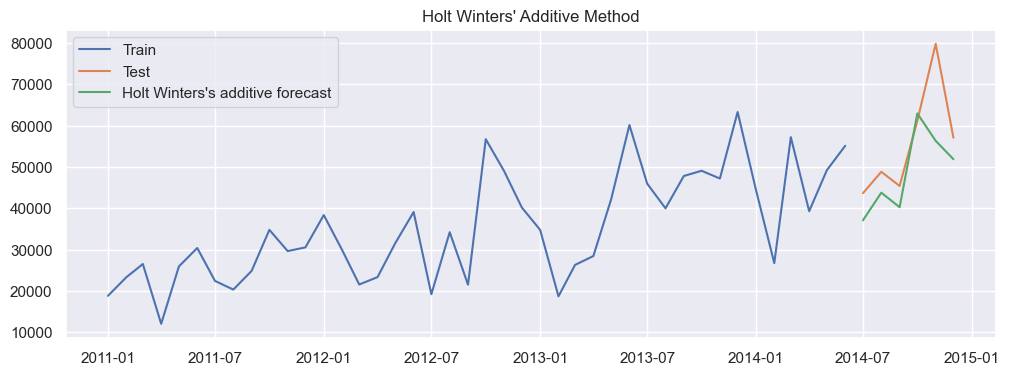

In [181]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

***We can see that we are able to capture good amount of seasonal variation and even the trend***

In [182]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64
0,Holt Winters' additive method,10624.26,13.02


#### 4.2.4 - Holt Winter's multiplicative method with trend and seasonality

In [183]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.005, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.0001, 'damping_trend': nan, 'initial_level': 25546.140294166653, 'initial_trend': 468.00483560606244, 'initial_seasons': array([1.14330212, 0.76036851, 0.69869713, 0.73937527, 1.02255778,
       1.32751953, 0.72524578, 0.90263868, 0.79512941, 1.50506931,
       1.26466724, 1.11542925]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


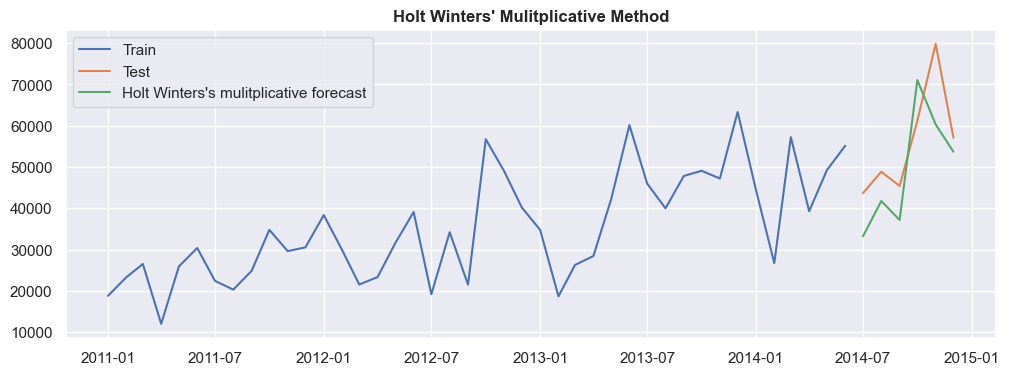

In [184]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method', fontweight='bold')
plt.show()

In [185]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17


From the Smoothing Techniques performed we can conclude that Holt Winter's Additive Method is giving the better forecast to of the sales for the 6 months, since the predicted sales are closer to the actual sales

### 4.3 - Auto Regressive Methods

In an autoregressive model, the regression technique is used to formulate a time series problem. In order to implement autoregressive models, we forecast future observations using a linear combination of past observations of the same variable

#### Stationarity vs non-stationary time series

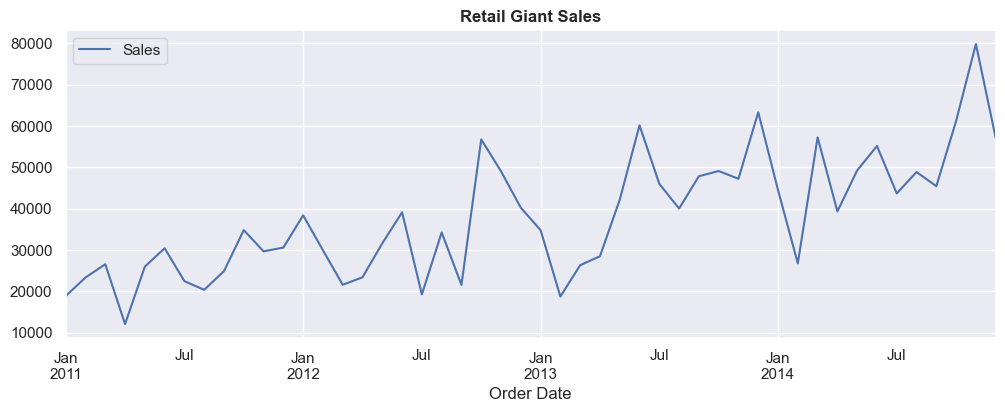

In [186]:
data['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Retail Giant Sales', fontweight='bold')
plt.show(block=False)

***Augmented Dickey-Fuller (ADF) test***
- Null Hypothesis  (𝐻0)
 : The series is not stationary  𝑝−𝑣𝑎𝑙𝑢𝑒>0.05
 
- Alternate Hypothesis: (𝐻1)
  The series is stationary  𝑝−𝑣𝑎𝑙𝑢𝑒<=0.05

In [187]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data['Sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.376024
Critical Values @ 0.05: -2.93
p-value: 0.011804


***p-value is less than 0.05. This means that the series is stationary.***

***Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test***

- Null Hypothesis  (𝐻0)
 : The series is stationary  𝑝−𝑣𝑎𝑙𝑢𝑒>0.05
 
- Alternate Hypothesis: (𝐻1)
  The series is not stationary  𝑝−𝑣𝑎𝑙𝑢𝑒<=0.05

In [188]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.103752
Critical Values @ 0.05: 0.46
p-value: 0.010000


***p-value is less than 0.05. This means that the series is not stationary.***

#### To make the series stationary, we need to perform transformation and differencing.

##### Box Cox transformation to make variance constant

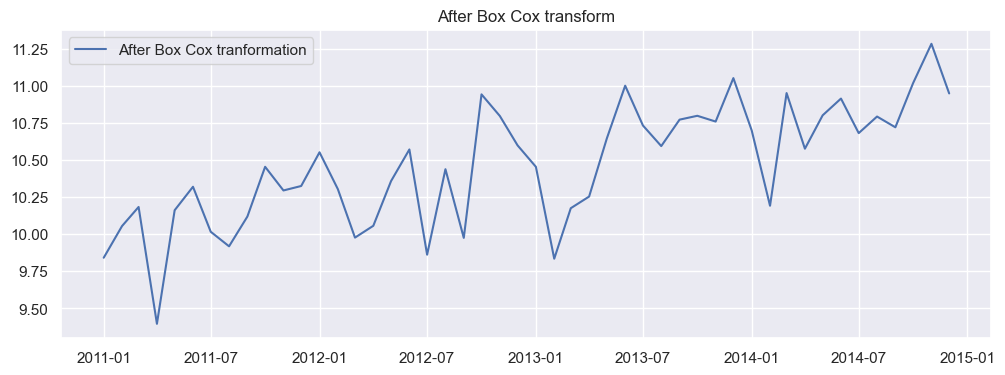

In [189]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Sales'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

##### Now we differentiate to remove trend

- Differencing is performed by subtracting the previous observation from the current observation.
- Differencing can remove both Trend and seasonality in a Time series.

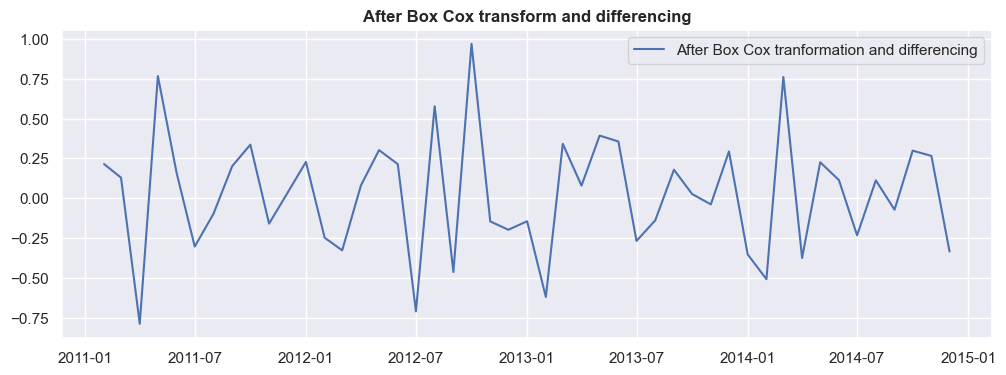

In [190]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing', fontweight='bold')
plt.show()

- ***The series looks Stationary***
- ***The fluctuations are under constant limits***
- ***The mean is also centered around zero***

In [191]:
data_boxcox_diff.dropna(inplace=True)

#### Now we reperform the tests for stationary

In [192]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.535011
Critical Values @ 0.05: -2.95
p-value: 0.000170


#### Inference : p-value is less than 0.05. This means that the series is stationary.

In [193]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.264930
Critical Values @ 0.05: 0.46
p-value: 0.100000


#### Inference : p-value is greater than 0.05. This means that the series is stationary.

***Thus after performing the Stationarity Tests we can see that we are able to convert a non-stationary series into a stationary series to build an Auto Regressive model.***

### Optional - AutoCorrelation Function (ACF)

We can calculate the correlation for time-series observations with observations from previous time steps, called lags. Since the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a dataset of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

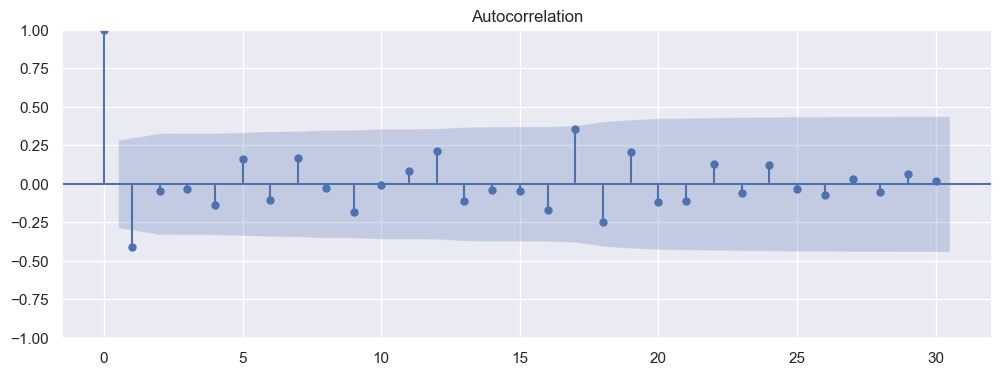

In [194]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

###  Partial AutoCorrelation Function (PACF)

The PACF only describes the direct relationship between an observation and its lag.
***The lag corresponding to the last significant peak before the autocorrelations drop off or become negligible is a good candidate for the order "p" of your AR model.***

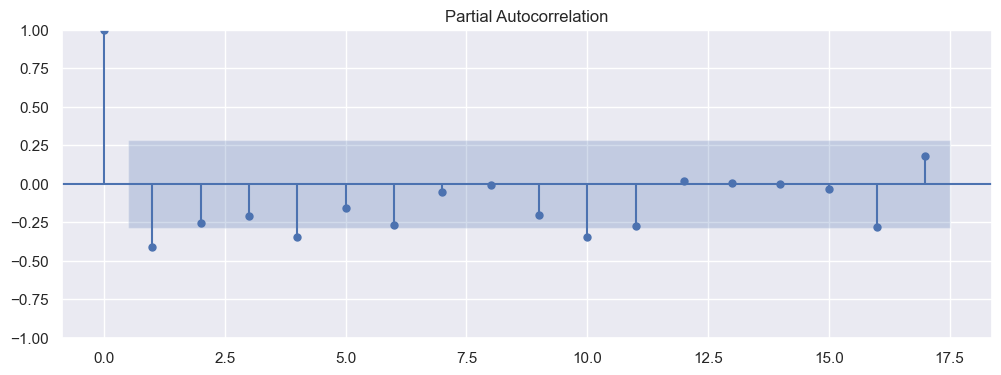

In [195]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(data_boxcox_diff, ax=plt.gca())
plt.show()

### Train-Test Split

In [196]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

***We will directly use p=1, q=1 and d=1 as the forecasts are relatively better for these values.***

## 5 - Auto regression method (AR)

- It models the future observation as a linear regression of one or more past observations.
- The parameter of the autoregressive model 'p' is calculated from the Partial Autocorrelation Function plot.
- ***Select p as the highest lag where partial autocorrelation is significantly high***

In [197]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const     0.024251
ar.L1    -0.406725
sigma2    0.124377
dtype: float64


##### Recover original time series

In [198]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

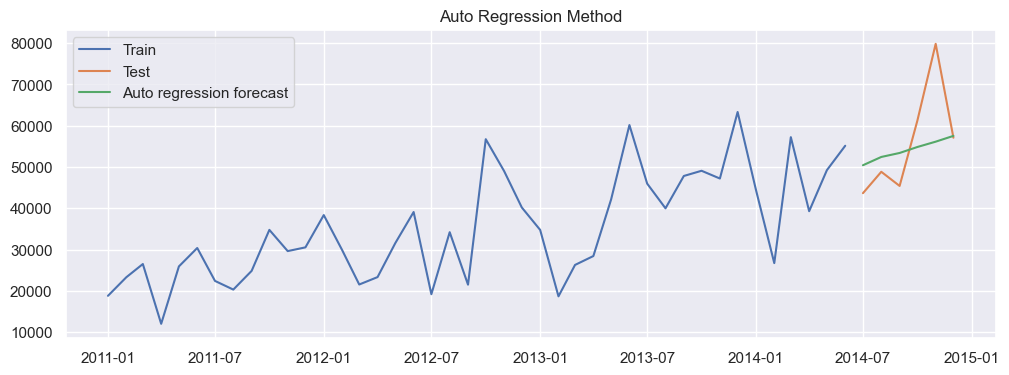

In [199]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

From the plot we can see that we are able to capture trend in the forecast but could not cature the seasonality

In [200]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17
0,Autoregressive (AR) method,10988.64,13.55


## 6 - Moving average method (MA)

- The Moving Average Model models the future forecasts using past forecast errors in a regression-like model.
- This model has a parameter ‘q’ called window size over which linear combination of errors are calculated.
- ***q is calculated from the Autocorrelation function plot. Select q as the highest lag beyond which autocorrelation dies down***

In [201]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const     0.021411
ma.L1    -0.999859
sigma2    0.079380
dtype: float64


In [202]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

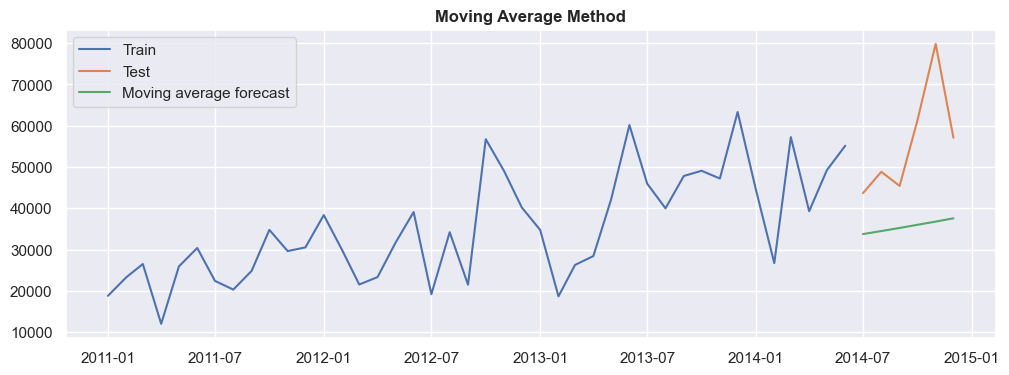

In [203]:
plt.figure(figsize=(12,4))
plt.plot(data['Sales'][:train_len], label='Train')
plt.plot(data['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method', fontweight='bold')
plt.show()

We are able to capture trend but not seasonality in the forecast

In [204]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17
0,Autoregressive (AR) method,10988.64,13.55
0,Moving Average (MA) method,23367.81,33.95


## 7 - Auto regression moving average method (ARMA)

- A time series that exhibits the characteristics of an  𝐴𝑅(𝑝)
  and/or  𝑀𝐴(𝑞)
  process can be modelled using an  𝐴𝑅𝑀𝐴(𝑝,𝑞)
  model
- It models the future observation as linear regression of one or more past observations and past forecast errors.

In [205]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.021465
ar.L1     0.074610
ma.L1    -0.999936
sigma2    0.079225
dtype: float64


In [206]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

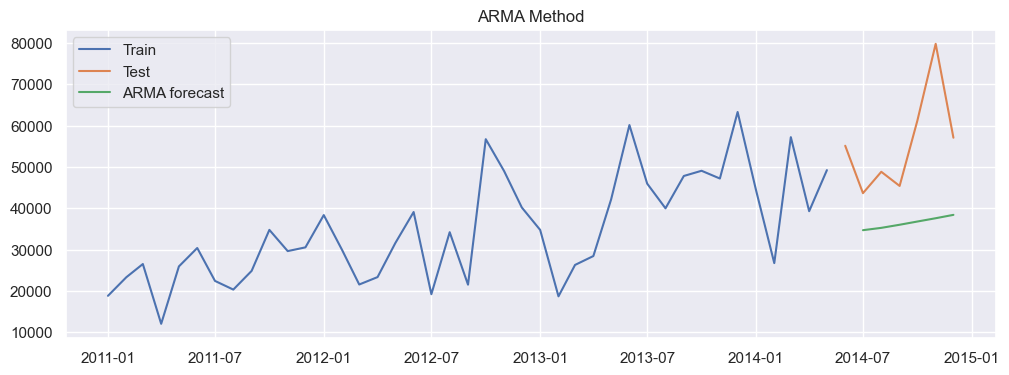

In [207]:
plt.figure(figsize=(12,4))
plt.plot( data['Sales'][:train_len-1], label='Train')
plt.plot(data['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [208]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17
0,Autoregressive (AR) method,10988.64,13.55
0,Moving Average (MA) method,23367.81,33.95
0,Autoregressive moving average (ARMA) method,22660.65,32.41


## 8 - Auto regressive integrated moving average (ARIMA) ?????

ARIMA model has three parameters
- p: Highest lag included in the regression model
- d: Degree of differencing to make the series stationary
- q: Number of past error terms included in the regression model
- 'd' is the differencing parameter. If d is 1, that means the series now has slope 0 and thus will have no trend. That means, the time series initially had trend.

In [209]:
model = ARIMA(train_data_boxcox_diff, order=(1, 1, 1))# p,d,q
model_fit = model.fit()
print(model_fit.params)

ar.L1    -0.392188
ma.L1    -0.999969
sigma2    0.127568
dtype: float64


In [210]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

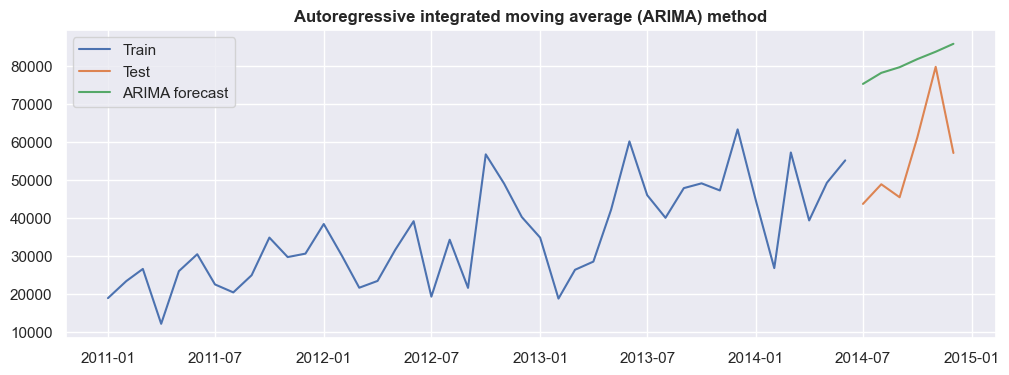

In [211]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method', fontweight='bold')
plt.show()

In [212]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17
0,Autoregressive (AR) method,10988.64,13.55
0,Moving Average (MA) method,23367.81,33.95
0,Autoregressive moving average (ARMA) method,22660.65,32.41


## 9  Seasonal auto regressive integrated moving average (SARIMA)

- SARIMA Model has both non seasonal elements and seasonal elements.
- SARIMA brings all the features of an ARIMA model with an extra feature - seasonality.
- SARIMA has six parameters along with seasonality.

In [213]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34913D-01    |proj g|=  1.78819D-01

At iterate    5    f=  2.69031D-01    |proj g|=  7.27611D-02

At iterate   10    f=  2.01279D-01    |proj g|=  7.01077D-02

At iterate   15    f=  1.91472D-01    |proj g|=  1.02376D-02

At iterate   20    f=  1.90489D-01    |proj g|=  2.12881D-02

At iterate   25    f=  1.90390D-01    |proj g|=  1.34952D-02

At iterate   30    f=  1.90370D-01    |proj g|=  6.36236D-03

At iterate   35    f=  1.90363D-01    |proj g|=  4.93617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [214]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

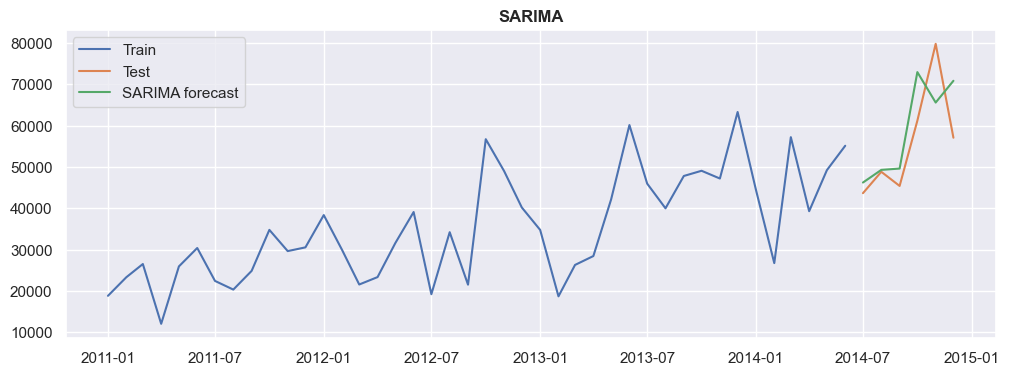

In [215]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('SARIMA',fontweight='bold')
plt.show()

In [216]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['(SARIMA) Seasonal autoregressive integrated moving average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,12355.97,17.47
0,Simple average method,24146.06,34.34
0,Simple moving average forecast,14756.73,15.82
0,Simple exponential smoothing forecast,14627.34,15.74
0,Holt's exponential smoothing method,11456.45,14.64
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17
0,Autoregressive (AR) method,10988.64,13.55
0,Moving Average (MA) method,23367.81,33.95
0,Autoregressive moving average (ARMA) method,22660.65,32.41


#### Among all the methods done in the ARIMA above, we can conclude that forecast done using SARIMA method is able to predict the sales closer to the actual values
#### RMSE and MAPE values for this method is the least among all the methods done